[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edikedik/eBoruta/blob/master/notebooks/demo.ipynb)

# `Boruta` usage demo

## Setup

In [1]:
# ! pip install seaborn xgboost scikit-learn

In [2]:
import logging
import typing as t

import numpy as np
import pandas as pd
import seaborn as sns
import shap
from catboost import CatBoostClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from eBoruta import eBoruta, TrialData, Features, Dataset, setup_logger

In [3]:
np.random.seed(666)

In [4]:
def plot_imp_history(df_history: pd.DataFrame):
    sns.lineplot(x='Step', y='Importance', hue='Feature', data=df_history)
    sns.lineplot(x='Step', y='Threshold', data=df_history, linestyle='--', linewidth=4)

## Basic usage

Single objective, `RandomForestClassifier`, default params.

In [5]:
x, y = make_classification(100, 10, n_informative=2)
boruta = eBoruta()
boruta.fit(x, y);

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

### Increase verbosity

Turn on logging to get a glimpse on what's going on

In [6]:
LOGGER = setup_logger(stdout_level=logging.DEBUG, logger=logging.getLogger('eBoruta'))

In [7]:
boruta = eBoruta(verbose=2)
boruta.fit(x, y);

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

2023-02-08 16:23:30,412 INFO [algorithm--fit]: Trial 1: sampled trial data with shapes x_train: (100, 20), y_train: (100,), x_test: (100, 20), y_test: (100,)
2023-02-08 16:23:30,572 INFO [algorithm--fit]: 40.0% (4) recorded as hits
2023-02-08 16:23:30,580 INFO [algorithm--_report_trial]: Out of 10: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2023-02-08 16:23:30,581 INFO [algorithm--_report_trial]: Total summary: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2023-02-08 16:23:30,585 INFO [algorithm--fit]: Trial 2: sampled trial data with shapes x_train: (100, 20), y_train: (100,), x_test: (100, 20), y_test: (100,)
2023-02-08 16:23:30,743 INFO [algorithm--fit]: 30.0% (3) recorded as hits
2023-02-08 16:23:30,750 INFO [algorithm--_report_trial]: Out of 10: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2023-02-08 16:23:30,751 INFO [algorithm--_report_trial]: Total summary: {'accepted': 0, 'rejected': 0, 'tentative': 10}
2023-02-08 16:23:30,755 INFO [algorithm--fit]: Trial 3: sampled 

### Access features and history

In [8]:
features = boruta.features_
features.accepted, features.rejected, features.tentative

(array(['1', '2', '7'], dtype=object),
 array(['3', '5', '6', '8', '9', '10'], dtype=object),
 array(['4'], dtype=object))

In [9]:
df = features.history
print(df.shape)
df.head()

(300, 6)


,Feature,Step,Importance,Hit,Decision,Threshold
0,1,1,0.081904,1,Tentative,0.017866
1,1,2,0.120700,1,Tentative,0.027072
2,1,3,0.102623,1,Tentative,0.020077
3,1,4,0.088259,1,Tentative,0.022102
4,1,5,0.077580,1,Tentative,0.018511


Note that `n_rows = n_steps * n_features`. `df.dropna()` cleans the table giving access to the last step for a feature where it was used.b

In [10]:
df.dropna().groupby('Feature').tail(1)

,Feature,Step,Importance,Hit,Decision,Threshold
7,1,8,0.094969,1,Accepted,0.023125
37,2,8,0.039087,1,Accepted,0.023125
67,3,8,0.005328,0,Rejected,0.023125
119,4,30,0.073942,1,Tentative,0.061385
127,5,8,0.008686,0,Rejected,0.023125
157,6,8,0.004911,0,Rejected,0.023125
187,7,8,0.209556,1,Accepted,0.023125
217,8,8,0.011646,0,Rejected,0.023125
247,9,8,0.007699,0,Rejected,0.023125
277,10,8,0.004598,0,Rejected,0.023125


- Query history to inspect the selection process

In [11]:
df[df['Feature'] == '7']

,Feature,Step,Importance,Hit,Decision,Threshold
180,7,1,0.196537,1,Tentative,0.017866
181,7,2,0.173083,1,Tentative,0.027072
182,7,3,0.176907,1,Tentative,0.020077
183,7,4,0.214924,1,Tentative,0.022102
184,7,5,0.219287,1,Tentative,0.018511
185,7,6,0.204183,1,Tentative,0.015110
186,7,7,0.183643,1,Tentative,0.025346
187,7,8,0.209556,1,Accepted,0.023125
188,7,9,NaN,NaN,Accepted,0.062966
189,7,10,NaN,NaN,Accepted,0.068240


- One can use history to produce plots

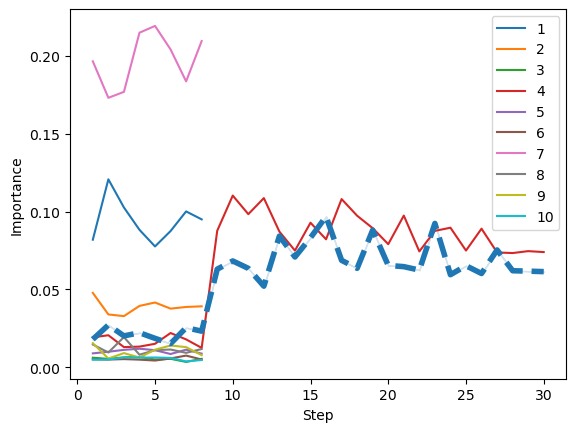

In [12]:
plot_imp_history(df)

### Explore params

In [13]:
?eBoruta

Init signature:
eBoruta(
    n_iter: 'int' = 30,
    classification: 'bool' = True,
    percentile: 'int' = 100,
    pvalue: 'float' = 0.05,
    test_size: 'int | float' = 0,
    test_stratify: 'bool' = False,
    shap_tree: 'bool' = True,
    shap_gpu_tree: 'bool' = False,
    shap_approximate: 'bool' = False,
    shap_check_additivity: 'bool' = False,
    importance_getter: 'ImportanceGetter | None' = None,
    verbose: 'int' = 1,
)
Docstring:      Flexible sklearn-compatible feature selection wrapper method.
Init docstring:
:param n_iter: The number of trials to run the algorithm.
:param classification: `True` if the task is classification else
    `False`.
:param percentile: Percentile of the shadow features as alternative
    to `max` in original Boruta.
:param pvalue: Level of rejecting the null hypothesis
    (the absence of a feature's importance).
:param test_size: The `test_size` param passed to :func:`train_test_split`.
    Can be a number or a fraction.
:param test_stratify

- Lower percentile threshold

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

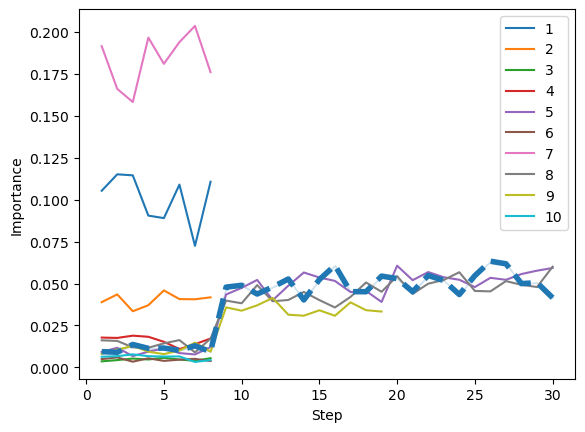

In [14]:
boruta = eBoruta(percentile=70).fit(x, y)
plot_imp_history(boruta.features_.history)

- Lower p-value

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

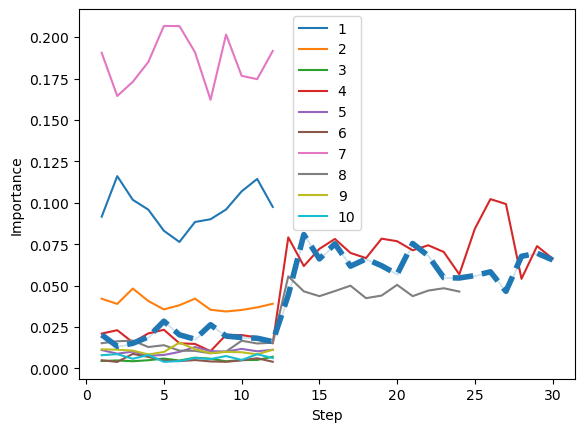

In [15]:
boruta = eBoruta(pvalue=0.005).fit(x, y)
plot_imp_history(boruta.features_.history)

- Apply rough fix

This won't overwrite existing `boruta.features_` but will return a new `Features` instance. In the latter, the history will remain unchanged, but the `accepted`, `rejected`, and `tentative` attributes will be modified accordingly.

In [16]:
fs = boruta.rough_fix(n_last_trials=10)

In [17]:
fs.accepted, fs.rejected, fs.tentative

(array(['1', '2', '4', '7'], dtype=object),
 array(['3', '5', '6', '8', '9', '10'], dtype=object),
 array([], dtype=object))

- Use test set

In [18]:
boruta = eBoruta(test_size=0.3, test_stratify=True).fit(x, y)

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

## Advanced usage

### Different models

In principle, the model can be __any__ callable defining a `fit` method -- classifier or regressor -- as long as the importance calculation is defined.
Note that one can define the latter manually (see below).

For instance, we'll use the `XGBClassifier` and `CatBoostClassifier` below.

- `XGBClassifier`

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated

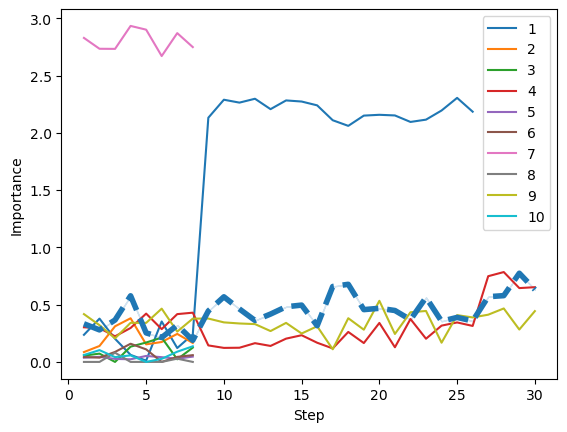

In [19]:
boruta = eBoruta().fit(x, y, model=XGBClassifier(n_estimators=20, verbosity=0))
plot_imp_history(boruta.features_.history)

- `CatBoostClassifier`

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

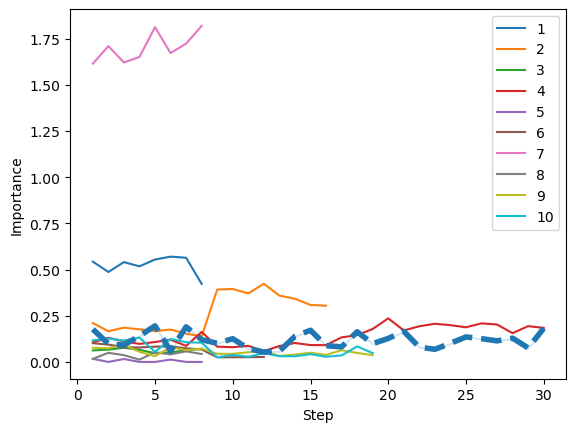

In [20]:
# shap with `approximate` is not supported for catboost currently
boruta = eBoruta().fit(x, y, model=CatBoostClassifier(iterations=20, verbose=False))
plot_imp_history(boruta.features_.history)

### Custom importance measure

Any callable accepting an estimator or estimator together with the `TrialData` object and returning a numpy array with shape `(n_test_features, )` will work.

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

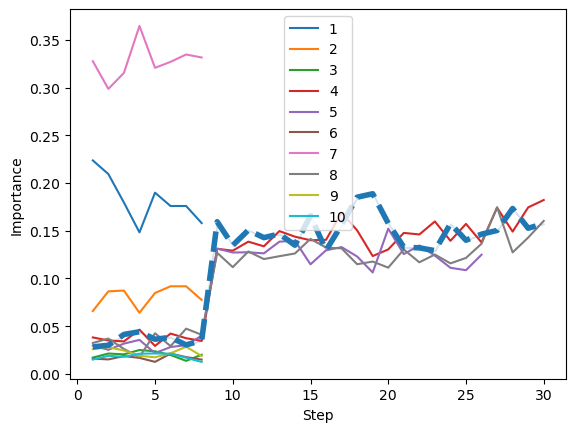

In [21]:
def get_imp(estimator):
    # equivalent to the builtin importance getter
    return estimator.feature_importances_

boruta = eBoruta(importance_getter=get_imp)
boruta.fit(x, y)
plot_imp_history(boruta.features_.history)

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

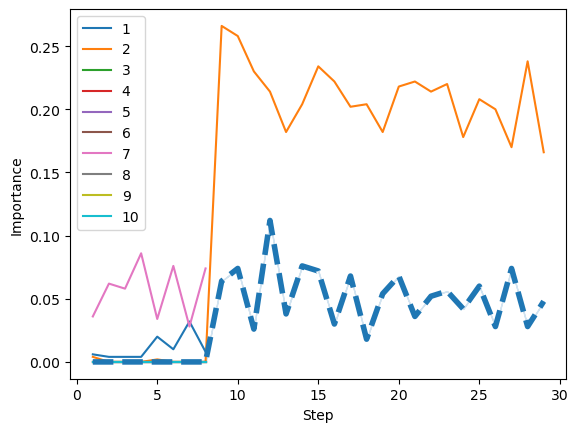

In [22]:
def get_permutation_imp(estimator: t.Any, trial_data: TrialData) -> np.ndarray:
    imp = permutation_importance(
        estimator, trial_data.x_test, trial_data.y_test, 
        scoring='accuracy', n_jobs=-1
    )
    return np.array(imp['importances_mean'])

# Let's also use a different estimator, just for the sake of it
boruta = eBoruta(
    importance_getter=get_permutation_imp
).fit(
    x, y, model=ExtraTreesClassifier(n_estimators=20)
)
plot_imp_history(boruta.features_.history)

#### Non-ensemble classifier with custom importance evaluation

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

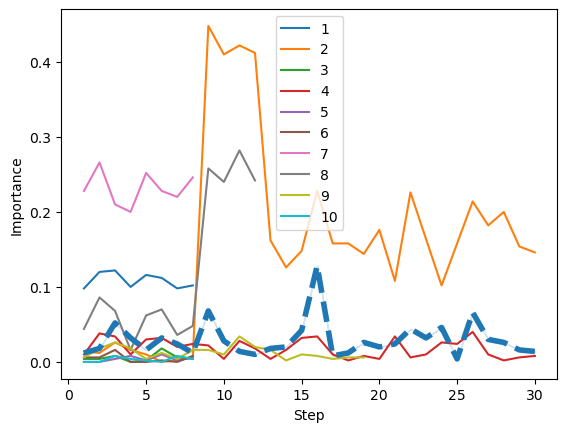

In [23]:
boruta = eBoruta(
    importance_getter=get_permutation_imp
).fit(
    x, y, model=LogisticRegression()
)
plot_imp_history(boruta.features_.history)

### Multiple objectives

Built-in approach is basically averaging importance of each feature per objective.
One can define a different aggregation strategy via custom importance getter.

In [24]:
y2 = np.array([[y_, y_] for y_ in y])

- Using built-in shap importance evaluation

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

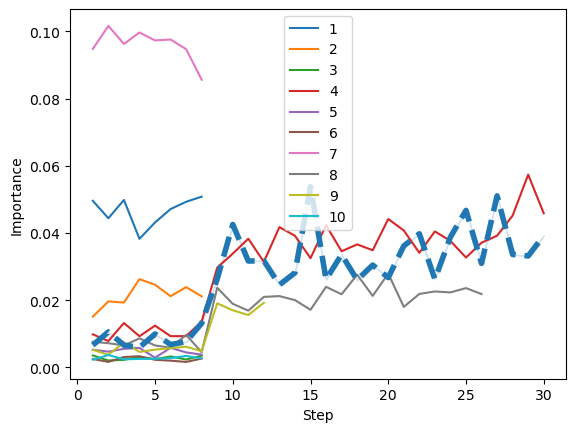

In [25]:
boruta = eBoruta().fit(x, y2)
plot_imp_history(boruta.features_.history)

- Using `feature_importances_` attribute

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

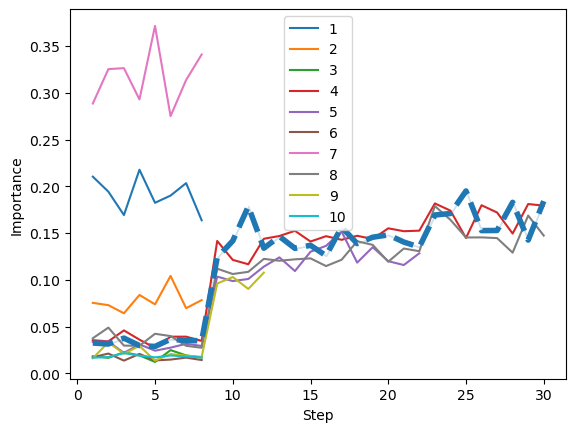

In [26]:
# Using shap importance
boruta = eBoruta(shap_tree=False).fit(x, y2)
plot_imp_history(boruta.features_.history)

- Using custom importance evaluation

Use-case: different aggregation strategy for multiple objectives. Below we'll use maximum of importances for a feature across objectives instead of the default mean.

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

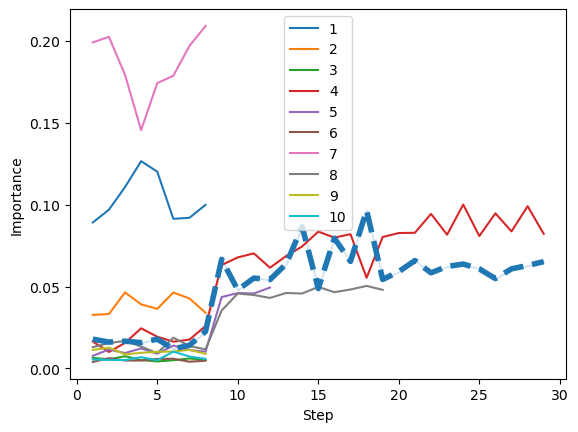

In [27]:
# Using custom aggregation
def get_imp(estimator, trial_data: TrialData):
    # equivalent to the builtin importance getter
    explainer = shap.explainers.Tree(estimator)
    imp = explainer.shap_values(trial_data.x_test, approximate=False)
    imp = np.max(np.vstack([np.abs(v).mean(0) for v in imp]), axis=0)
    return imp


boruta = eBoruta(importance_getter=get_imp).fit(x, y)
plot_imp_history(boruta.features_.history)

### Using `Callback`s

It can be any callable (including classes with mutable state), accepting and returning `(Estimator, Feature, Dataset, Trial)`.
Check `callbacks` module for additional examples.

- `CatBoostClassifier` with categorical features

In [28]:
def handle_catboost_categorical(
    estimator: CatBoostClassifier, features: Features, 
    dataset: Dataset, trial_data: TrialData, **kwargs
):
    params = estimator.get_params()
    params['cat_features'] = [c for c in trial_data.x_test.columns if 'cat' in c]
    estimator = estimator.__class__(**params)
    return estimator, features, dataset, trial_data, kwargs

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

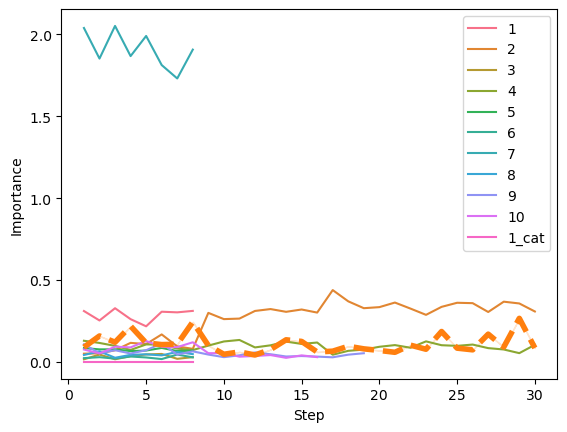

In [29]:
x_cat = boruta.dataset_.x.copy()
x_cat['1_cat'] = pd.Series(x_cat['1'].round(0).astype(int).astype('category'))

boruta = eBoruta().fit(
    x_cat, y, model=CatBoostClassifier(iterations=20, verbose=False),
    callbacks_trial_start=[handle_catboost_categorical],
)
plot_imp_history(boruta.features_.history)

- `CatBoostClassifier` with adjusted number of iterations

In [30]:
class AdjustIterations:
    def __init__(self, min_iterations: int = 5):
        self.min_iterations = min_iterations

    def __call__(self, estimator: CatBoostClassifier, features: Features, dataset: Dataset, trial_data: TrialData, **kwargs):
        num_features = trial_data.x_test.shape[1]
        num_iterations = max([self.min_iterations, num_features // 2])
        params = estimator.get_params()
        params['iterations'] = num_iterations
        estimator = estimator.__class__(**params)
        print(f'Set the number of iterations to {estimator.get_param("iterations")} (num_features={num_features})')
        return estimator, features, dataset, trial_data, kwargs

Boruta trials:   0%|          | 0/30 [00:00<?, ?it/s]

Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 10 (num_features=20)
Set the number of iterations to 6 (num_features=12)
Set the number of iterations to 6 (num_features=12)
Set the number of iterations to 6 (num_features=12)
Set the number of iterations to 6 (num_features=12)
Set the number of iterations to 5 (num_features=9)
Set the number of iterations to 5 (num_features=9)
Set the number of iterations to 5 (num_features=9)
Set the number of iterations to 5 (num_features=9)
Set the number of iterations to 5 (num_features=8)
Set the number of iterations to 5 (num_features=8)
Set the number of iterations to 5 (num_features=8)
Set the num

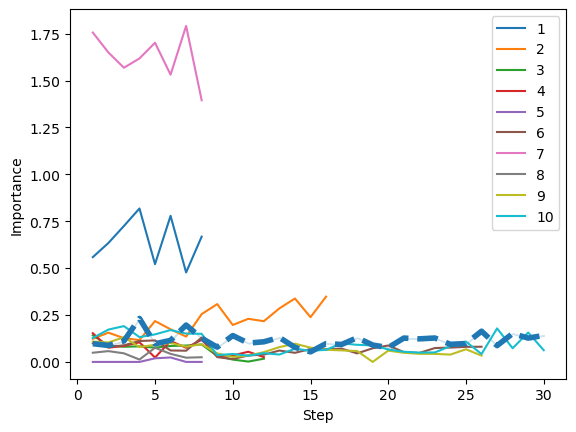

In [31]:
boruta = eBoruta().fit(
    x, y, model=CatBoostClassifier(iterations=20, verbose=False), 
    callbacks_trial_start=[AdjustIterations()]
)
plot_imp_history(boruta.features_.history)